In [1]:
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

200805-01:29:00,559 nipype.utils WARNING:
	 A newer version (1.5.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [2]:
experiment_dir = '/home/neuro/nipype_tutorial/output'
output_dir = 'datasink'
working_dir = 'workingdir_mg'

# list of subject identifiers
subject_list = ['02', '03', '04', '07', '08', '09']

# TR of functional images
with open('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [4]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

In [5]:
!cat /home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


In [6]:
import pandas as pd
trialinfo = pd.read_table('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)

('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)

('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)



In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch

    trialinfo = pd.read_table('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_ses-test_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions


In [10]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])


200805-01:29:18,351 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir_mg/l1analysis/graph.png (graph2use=colored, simple_form=True).


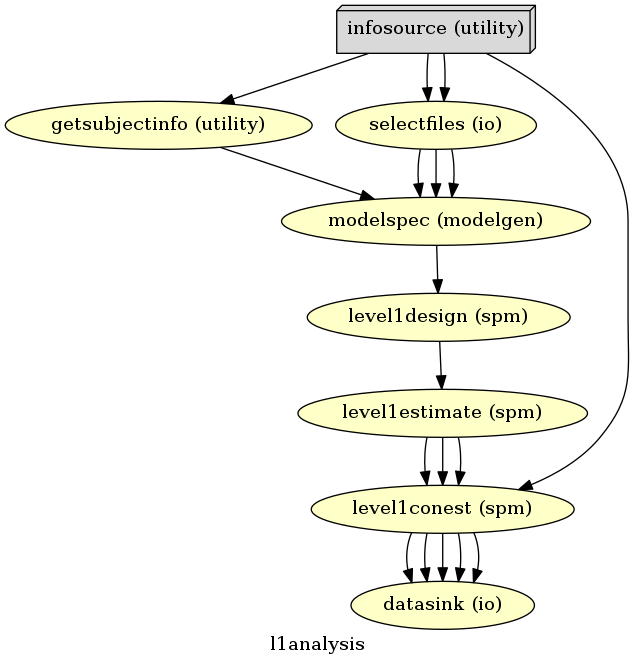

In [11]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))


In [12]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 8})

200805-01:29:20,811 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
200805-01:29:20,878 nipype.workflow INFO:
	 Running in parallel.
200805-01:29:20,883 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 24 jobs ready. Free memory (GB): 28.16/28.16, Free processors: 8/8.
200805-01:29:20,932 nipype.workflow INFO:
	 [Job 0] Cached (l1analysis.getsubjectinfo).
200805-01:29:20,934 nipype.workflow INFO:
	 [Job 7] Cached (l1analysis.getsubjectinfo).
200805-01:29:20,938 nipype.workflow INFO:
	 [Job 14] Cached (l1analysis.getsubjectinfo).
200805-01:29:20,941 nipype.workflow INFO:
	 [Job 21] Cached (l1analysis.getsubjectinfo).
200805-01:29:20,945 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir_mg/l1analysis/_fwhm_id_4_subject_id_08/selectfiles".
200805-01:29:20,951 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200805-01:29:2

200805-01:29:22,898 nipype.workflow ERROR:
	 Node selectfiles.a08 failed to run on host 9b10d529fbe3.
200805-01:29:22,899 nipype.workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/crash-20200805-012922-neuro-selectfiles.a08-a1d5db97-ae09-4dc2-a458-fd55671084fe.pklz
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
TypeError: __init__() got an unexpected keyword argument 'initializer'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)

200805-01:29:24,899 nipype.workflow ERROR:
	 Node selectfiles.a05 failed to run on host 9b10d529fbe3.
200805-01:29:24,900 nipype.workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/crash-20200805-012924-neuro-selectfiles.a05-6cf1bbc0-c1ba-4553-80c4-11db27342979.pklz
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
TypeError: __init__() got an unexpected keyword argument 'initializer'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)

200805-01:29:26,899 nipype.workflow ERROR:
	 Node selectfiles.a02 failed to run on host 9b10d529fbe3.
200805-01:29:26,900 nipype.workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/crash-20200805-012926-neuro-selectfiles.a02-e3a43273-2551-456d-bcc3-963a0ef58607.pklz
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
TypeError: __init__() got an unexpected keyword argument 'initializer'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)

200805-01:29:28,901 nipype.workflow ERROR:
	 could not run node: l1analysis.selectfiles.a04
200805-01:29:28,902 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20200805-012924-neuro-selectfiles.a04-e842c89a-3b24-4f21-baa1-bc9ac911715e.pklz
200805-01:29:28,902 nipype.workflow ERROR:
	 could not run node: l1analysis.selectfiles.a03
200805-01:29:28,902 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20200805-012926-neuro-selectfiles.a03-7a6b70b8-d192-4539-8e48-2699120aa534.pklz
200805-01:29:28,903 nipype.workflow ERROR:
	 could not run node: l1analysis.selectfiles.a02
200805-01:29:28,903 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20200805-012926-neuro-selectfiles.a02-e3a43273-2551-456d-bcc3-963a0ef58607.pklz
200805-01:29:28,903 nipype.workflow ERROR:
	 could not run node: l1analysis.selectfiles.a01
200805-01:29:28,904 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20200805-012926-neuro-selectfiles.a0

RuntimeError: Workflow did not execute cleanly. Check log for details

In [13]:


!tree /home/neuro/nipype_tutorial/output/datasink/1stLevel



/home/neuro/nipype_tutorial/output/datasink/1stLevel
├── sub-02
│   ├── spmF_0008.nii
│   ├── spmF_0009.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   ├── spmT_0005.nii
│   ├── spmT_0006.nii
│   └── spmT_0007.nii
├── sub-03
│   ├── spmF_0008.nii
│   ├── spmF_0009.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   ├── spmT_0005.nii
│   ├── spmT_0006.nii
│   └── spmT_0007.nii
├── sub-04
│   ├── spmF_0008.nii
│   ├── spmF_0009.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   ├── spmT_0005.nii
│   ├── spmT_0006.nii
│   └── spmT_0007.nii
├── sub-07
│   ├── spmF_0008.nii
│   ├── spmF_0009.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   ├── spmT_0005.nii
│   ├── spmT_0006.nii
│   └── spmT_0007.nii
├── sub-08
│   ├── spmF_0008.nii
│   ├── spmF_0

In [19]:


%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt



In [20]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/home/neuro/nipype_tutorial/output/datasink/1stLevel/sub-02/SPM.mat',
                 struct_as_record=False)

In [15]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/home/neuro/nipype_tutorial/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz'

In [21]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

In [22]:
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

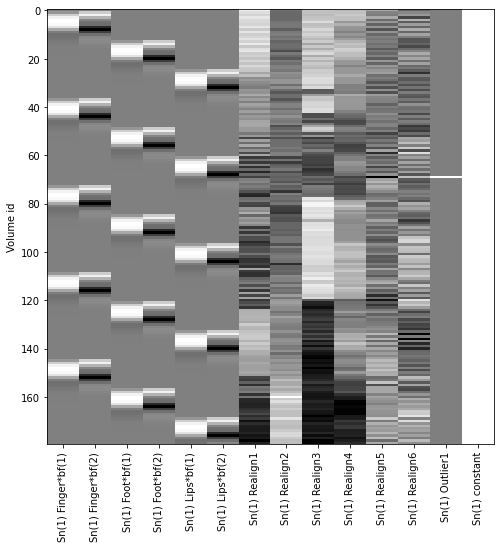

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

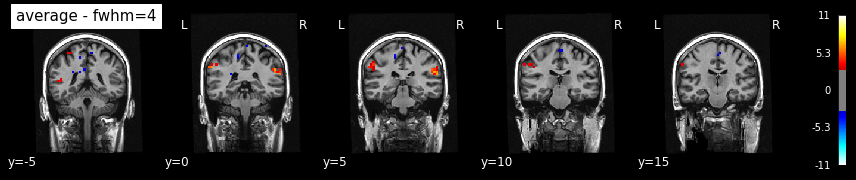

In [17]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/output/datasink/1stLevel/sub-02/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

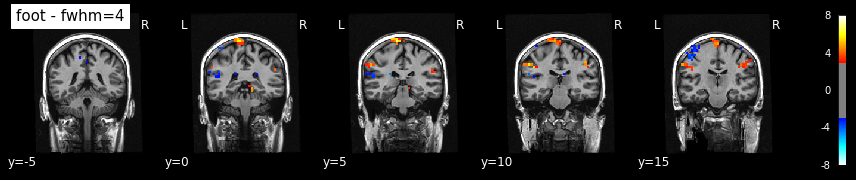

In [18]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/output/datasink/1stLevel/sub-02/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

In [24]:
import nibabel as nb
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_glass_brain
%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


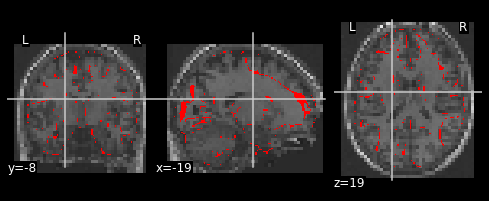

In [53]:
# Load GM probability map of TPM.nii
img = nb.load('/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii')
GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)

# Plot normalized subject anatomy
display = plot_anat('/home/neuro/nipype_tutorial/output/datasink/normalized/sub-07/wsub-07_ses-test_T1w.nii',
                    dim=-0.1)

# Overlay in edges GM map
display.add_edges(GM_template)

In [40]:
print(img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (121, 145, 121, 6)
affine: 
[[  -1.5    0.     0.    90. ]
 [   0.     1.5    0.  -126. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 121 145 121   6   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.5  1.5  1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'tissue probability map'
aux_file  